# Mesh preprocessing

## Libraries

In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pymeshlab
import math
import vedo
import logging
from tqdm import tqdm
import shutil
import time
import trimesh
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')


## Global variables

In [107]:
# Override
OVERWRITE = True

# Outlier thresholds
LOW_THRESHOLD = 500
HIGH_THRESHOLD = 10000


# Target vertices
TARGET_VERTICES = 5000

# Tolerance level
TOLERANCE = 0.2

# Upper and lower bounds
LOWER_BOUND = TARGET_VERTICES-TARGET_VERTICES*TOLERANCE
UPPER_BOUND = TARGET_VERTICES+TARGET_VERTICES*TOLERANCE

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger()

# Dataset and Output paths
DATASET_PATH = 'datasets/dataset_snippet_small'
RESAMPLED_SHAPES_PATH = 'datasets/dataset_snippet_small_resample'
OUTPUT_PATH = 'outputs'

# Function to handle directory creation with optional overwrite
def create_directory(path, overwrite=False, logger=logger):
    """
    Create a directory. If overwrite is True, delete the directory if it exists and recreate it.
    Parameters:
        path (str): The path of the directory to create.
        overwrite (bool): Whether to overwrite the directory if it exists.
    """
    if overwrite and os.path.exists(path):
        # Remove the directory and its contents if overwrite is True
        shutil.rmtree(path)
        logger.info(f"Directory '{path}' existed and was removed for overwriting.")
    
    # Now create the directory
    os.makedirs(path, exist_ok=True)
    logger.info(f"Directory '{path}' created.")


# Create OUTPUT, RESAMPLED_SHAPES directories and CSV paths 
create_directory(OUTPUT_PATH, overwrite=OVERWRITE, logger=logger)
create_directory(RESAMPLED_SHAPES_PATH, overwrite=OVERWRITE, logger=logger)

original_csv_path = os.path.join(OUTPUT_PATH, "shapes_data.csv")
resampled_csv_path = os.path.join(OUTPUT_PATH, "resampled_shapes_data.csv")

# Counter of shapes excluded
EXCLUDED = 0

02:35:29 [INFO]: Directory 'outputs' existed and was removed for overwriting.
02:35:29 [INFO]: Directory 'outputs' created.
02:35:29 [INFO]: Directory 'datasets/dataset_snippet_small_resample' existed and was removed for overwriting.
02:35:29 [INFO]: Directory 'datasets/dataset_snippet_small_resample' created.


## Dataset analyzation

In [108]:
def analyze_shape(filepath=False, mesh=None):
    '''
    Analyze a 3D shape using Trimesh and return the required information.
    :param filepath: Path to the OBJ file
    '''
    # Load the mesh using Trimesh
    if filepath:
        mesh = trimesh.load(filepath)
    
    num_vertices = len(mesh.vertices)  # Number of vertices
    num_faces = len(mesh.faces)  # Number of faces (triangles)
    face_type = "Triangles"  # Face type (triangles by default for OBJ)
    
    # Axis-aligned bounding box (AABB)
    aabb_min, aabb_max = mesh.bounds
    bounding_box = {
        "min_bound": aabb_min.tolist(),  # Min corner of the bounding box
        "max_bound": aabb_max.tolist()   # Max corner of the bounding box
    }

    is_manifold = mesh.is_watertight  # Has holes or not
    outlier_low = True if num_vertices <= LOW_THRESHOLD else False  # Low outlier
    outlier_high = True if num_vertices >= HIGH_THRESHOLD else False  # High outlier

    # Return dictionary of extracted data
    return {
        "vertices": num_vertices,
        "faces": num_faces,
        "face_type": face_type,
        "bounding_box": bounding_box,
        "is_manifold": is_manifold,
        "outlier_low": outlier_low,
        "outlier_high": outlier_high
    }
    

def analyze_databset(labeled_db_path):
    '''
    Iteratively analyze all 3D shapes within the database.
    :param labeled_db_path: Path to the root of the labeled database
    '''
    results = []

    for category in os.listdir(labeled_db_path):
        category_path = os.path.join(labeled_db_path, category)

        if os.path.isdir(category_path):
            for shape_file in os.listdir(category_path):
                if shape_file.endswith('.obj'):
                    filepath = os.path.join(category_path, shape_file)
                    shape_info = {}
                    shape_info["file_name"] = shape_file  # Add the filename of the shape
                    shape_info["obj_class"] = category  # Add class (category) of the shape
                    # Analyze each shape
                    shape_info.update(analyze_shape(filepath))
                    shape_info["file_path"] = os.path.join(category_path, shape_file)  # Add class (category) of the shape
                    
                    results.append(shape_info)

    return results

## Visualization

In [109]:
# Visualize
def plot_distribution(df, title, bins=30):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df['vertices'], bins=bins, color='purple', alpha=0.7)
    plt.title(f'{title} - Distribution of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Number of Shapes')
    plt.subplot(1, 2, 2)
    plt.hist(df['faces'], bins=bins, color='red', alpha=0.7)
    plt.title(f'{title} - Distribution of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Number of Shapes')
    plt.tight_layout()
    plt.show()

# Statistics
def compare_statistics(original_df, resampled_df):
    print("Statistics comparison:")
    for column in ['vertices', 'faces']:
        print(f"\n{column.capitalize()}:")
        print("Before Resampling:")
        print(original_df[column].describe())
        print("\nAfter Resampling:")
        print(resampled_df[column].describe())

## Process meshes

### Cleaning

In [110]:
def clean_mesh(mesh):
    """
    Clean the mesh by removing duplicate faces and vertices, repairing holes, and ensuring consistent orientation.

    Parameters:
        mesh (vedo.Mesh): The mesh object to clean.
    Returns:
        vedo.Mesh or None: The cleaned mesh object, or None if the mesh cannot be cleaned.
    """

    try:
        mesh_copy = deepcopy(mesh)
        mesh_copy.remove_degenerate_faces()          # Remove degenerate (zero-area) faces
        mesh_copy.merge_vertices()                   # Merge vertices (remove duplicated vertices)
        mesh_copy.remove_unreferenced_vertices()     # Remove vertices not referenced by any faces
        mesh_copy.remove_infinite_values()           # Remove vertices with infinite/NaN coordinates
        mesh_copy.fill_holes()                       # Fill in missing faces to close holes
        mesh_copy.fix_normals()                      # Fix any incorrect face or vertex normals


        # Check if the mesh has any faces left
        if len(mesh_copy.faces) == 0:
            logger.warning("Mesh has no faces left after cleaning.")
            return None

        # logger.info(f"Finished cleaning. Vertices {len(mesh.vertices)} - {len(mesh_copy.vertices)} :: Faces {len(mesh.faces)} - {len(mesh_copy.faces)} faces.")
        return mesh_copy

    except Exception as e:
        logger.error(f"Error during mesh cleaning: {e}")
        return None
    

def clean_dataset(df):
    """
    Process and resample meshes, save valid ones, and skip invalid ones.

    Parameters:
        df (pd.DataFrame): DataFrame containing information about each mesh to process.
        resampled_root (str): Root directory to save resampled meshes.

    Returns:
        pd.DataFrame: DataFrame of valid processed meshes.
        pd.DataFrame: DataFrame of skipped meshes.
    """
    global EXCLUDED
    shapes_data_cleaned = []

    for _, row in df.iterrows():
        file_path = row['file_path']
        
        try:
            # Load the mesh using Trimesh
            mesh = trimesh.load(file_path)
            # Clean mesh
            cleaned_mesh = clean_mesh(mesh)
            
            new_data = analyze_shape(mesh=cleaned_mesh)
            
            row['is_manifold'] = new_data['is_manifold']
            row['bounding_box'] = new_data['bounding_box']
            row['vertices'] = new_data['vertices']
            row['faces'] = new_data['faces']
            row['outlier_high'] = new_data['outlier_high']
            row['outlier_low'] = new_data['outlier_low']
            
            shapes_data_cleaned.append(row)

        except Exception as e:
            logger.error(f"Error processing mesh {file_path}: {e}")
    
    return pd.DataFrame(shapes_data_cleaned)



### Resampling

In [111]:
def process_meshes(df, resampled_root):
    """
    Process and resample meshes, save valid ones, and skip invalid ones.

    Parameters:
        df (pd.DataFrame): DataFrame containing information about each mesh to process.
        resampled_root (str): Root directory to save resampled meshes.

    Returns:
        pd.DataFrame: DataFrame of valid processed meshes.
        pd.DataFrame: DataFrame of skipped meshes.
    """
    global EXCLUDED

    for _, row in df.iterrows():
        obj_class = row['obj_class']
        file_name = row['file_name']
        file_path = row['file_path']
        resampled_file_path = os.path.join(resampled_root, obj_class, file_name)
        
        try:
            # Load the mesh using Trimesh
            mesh = trimesh.load(file_path)
            
            # Adjust the mesh complexity
            resampled_mesh = adjust_mesh_complexity(mesh, row)
            
            # Ensure the directory for resampled file exists
            os.makedirs(os.path.dirname(resampled_file_path), exist_ok=True)

            # Save the resampled mesh
            resampled_mesh.export(resampled_file_path)
        
        except Exception as e:
            logger.error(f"Error processing mesh {file_path}: {str(e)}")
        

def adjust_mesh_complexity(mesh, row, max_iterations=10):
    """
    Adjust mesh complexity by refining low-poly meshes and simplifying high-poly meshes.

    Parameters:
        mesh (vedo.Mesh): The mesh object to adjust.
        row (dict): Dictionary containing outlier information (whether low or high outlier).
        target_vertices (int): Target number of vertices.
        max_iterations (int): Maximum number of iterations allowed.
    Returns:
        vedo.Mesh: The adjusted and cleaned mesh object.
    """
    current_vertices = len(mesh.vertices)
    for i in range(max_iterations):
        current_vertices = len(mesh.vertices)
        if current_vertices<LOWER_BOUND:
            mesh = mesh.subdivide()
            # logger.info(f"Resample low complexity mesh (Current vertices: {current_vertices})...")
        elif current_vertices>UPPER_BOUND:
            mesh = mesh.simplify_quadric_decimation(percent=0.2)
            # logger.info(f"Simplifying high complexity mesh (Current vertices: {current_vertices})...")
        else:
            # logger.info(f"BREAK:: (Current vertices: {current_vertices})...")
            break

    return mesh

## Main

02:35:29 [INFO]: # Step 1. # Analyzing database and collecting statistics...
02:35:32 [INFO]: Original shapes data saved to 'outputs\shapes_data.csv'


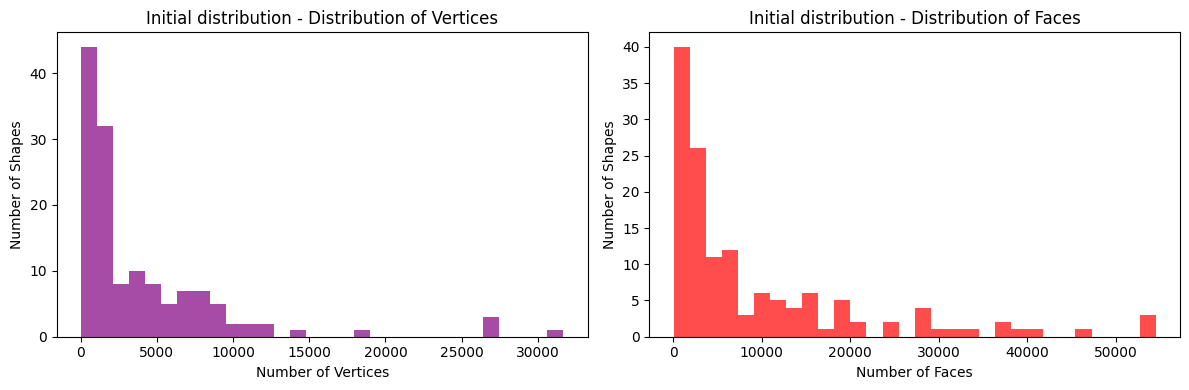

02:35:32 [INFO]: # Step 2. # Clean meshes...
02:35:54 [INFO]: Cleaned shapes data saved to 'outputs/shapes_data_cleaned.csv'


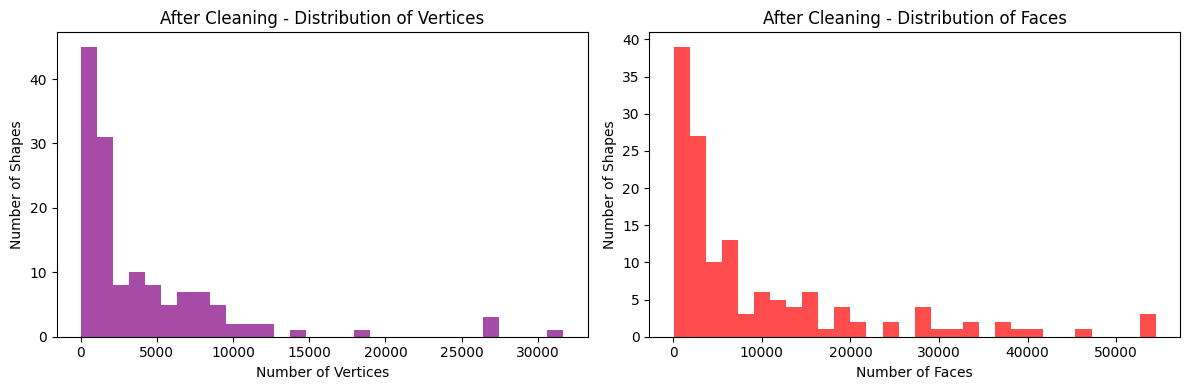

02:35:54 [INFO]: # Step 3. # Resample meshes...
02:36:20 [INFO]: # Step 4. # Analyzing resampled database and collecting statistics...
02:36:25 [INFO]: Original shapes data saved to 'outputs\resampled_shapes_data.csv'


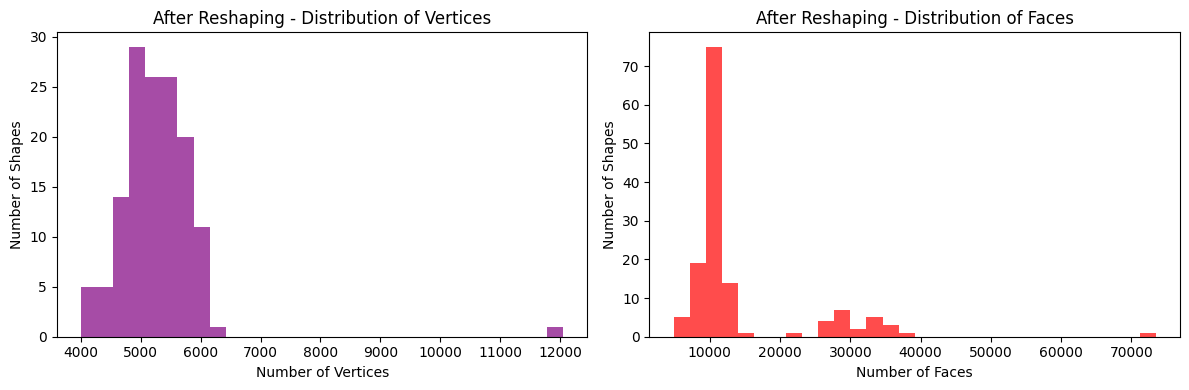

Deleted file: datasets/dataset_snippet_small_resample\Bookset\D01199.obj
Deleted file: datasets/dataset_snippet_small_resample\Jet\m1266.obj
Deleted file: datasets/dataset_snippet_small_resample\Shelf\m851.obj
Deleted file: datasets/dataset_snippet_small_resample\Wheel\m741.obj


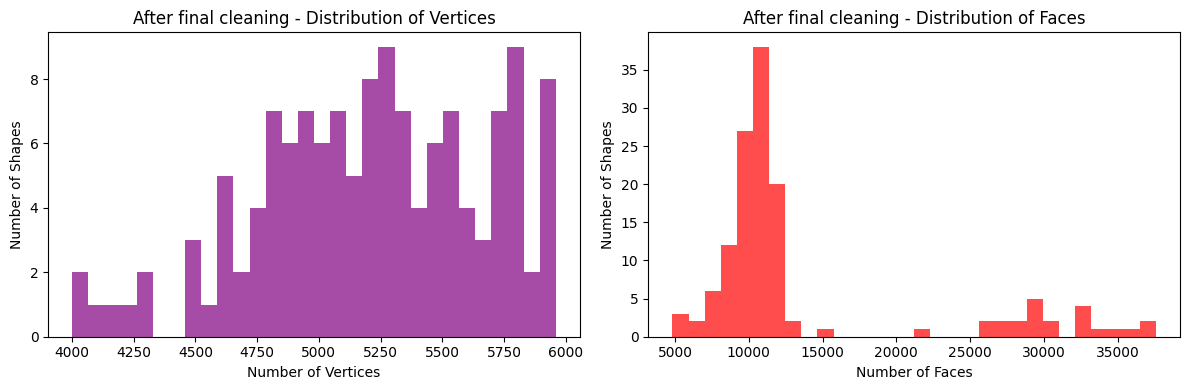

In [112]:
def main():
    # -------------------------------------------- ANALYZE ORIGINAL SHAPES -------------------------------------------- #
    if not os.path.exists(original_csv_path) or OVERWRITE:
        logger.info("# Step 1. # Analyzing database and collecting statistics...")
        shapes_data = analyze_databset(DATASET_PATH)
        shapes_data_df = pd.DataFrame(shapes_data)
        shapes_data_df.to_csv(original_csv_path, index=False)
        logger.info(f"Original shapes data saved to '{original_csv_path}'")
    else:
        shapes_data_df = pd.read_csv(original_csv_path)
        logger.info(f"# Step 1. # Loaded existing original shapes data from '{original_csv_path}'")

    plot_distribution(shapes_data_df, "Initial distribution")
    
    # ----------------------------------------------- CLEAN SHAPES ----------------------------------------------- #
    logger.info("# Step 2. # Clean meshes...")
    shapes_data_df = pd.read_csv('outputs/shapes_data.csv')
        
    # Start processing the meshes
    shapes_data_cleaned_df = clean_dataset(shapes_data_df)
    shapes_data_cleaned_path = 'outputs/shapes_data_cleaned.csv'
    shapes_data_cleaned_df.to_csv(shapes_data_cleaned_path, index=False)
    logger.info(f"Cleaned shapes data saved to '{shapes_data_cleaned_path}'")
    
    plot_distribution(shapes_data_cleaned_df, "After Cleaning")
    
    # ----------------------------------------------- RESAMPLE SHAPES ----------------------------------------------- #
    if not os.path.exists(RESAMPLED_SHAPES_PATH) or OVERWRITE:
        logger.info("# Step 3. # Resample meshes...")
        process_meshes(shapes_data_cleaned_df, RESAMPLED_SHAPES_PATH)
    
    # ----------------------------------------------- ANALYZE RESAMPLED SHAPES ----------------------------------------------- #
    if not os.path.exists(resampled_csv_path) or OVERWRITE:
        logger.info("# Step 4. # Analyzing resampled database and collecting statistics...")
        resampled_shapes_data = analyze_databset(RESAMPLED_SHAPES_PATH)
        resampled_shapes_data_df = pd.DataFrame(resampled_shapes_data)
        resampled_shapes_data_df.to_csv(resampled_csv_path, index=False)
        logger.info(f"Original shapes data saved to '{resampled_csv_path}'")
    else:
        resampled_shapes_data_df = pd.read_csv(resampled_csv_path)
        logger.info(f"# Step 4. # Loaded existing resampled shapes data from '{resampled_csv_path}'")

    plot_distribution(resampled_shapes_data_df, "After Reshaping")
    
    # ----------------------------------------------- REMOVE SHAPES STILL OUTLIERS ----------------------------------------------- #
    final_shapes_df = resampled_shapes_data_df[(resampled_shapes_data_df['vertices'] >= LOWER_BOUND) & 
                                               (resampled_shapes_data_df['vertices'] <= UPPER_BOUND)]
    
    final_shapes_df.to_csv("outputs/final_shapes.csv")
    
    outliers_df = resampled_shapes_data_df[(resampled_shapes_data_df['vertices'] < LOWER_BOUND) | (resampled_shapes_data_df['vertices'] > UPPER_BOUND)]
    
    # Delete files for the outliers based on the 'path' column
    for file_path in outliers_df['file_path']:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        else:
            print(f"File not found: {file_path}")

    plot_distribution(final_shapes_df, "After final cleaning")


if __name__ == "__main__":
    main()